Consider the daily open, high, low, close and volume of Bitcoin to US Dollar exchange rate from 1st January 2015 to 31 December 2020, and the daily log returns calculated from close-to-close data. The purpose of this assignment is to analyze the volatility series of daily asset returns.

All models should include the mean and volatility equations. You should always perform model checking to confirm the adequacy of a fitted model. In all cases, please share the results as well as the source code and data.

* Obtain the data from online sources. Disclose the method and source you used for downloading.

In [1]:
# Raw Package

import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

df = yf.download(tickers='BTC-USD', start="2015-01-01", end="2020-12-31", interval = '1d')
df['log_close'] = np.log(df.Close)
df['return'] = df.Close.pct_change().dropna()
df['log_return'] = np.log(df['Close']/df['Close'].shift(1)).fillna(0)
df['squared_log_return'] = np.power(df['log_return'], 2)

# Scale up 100x
df['return_100x'] = np.multiply(df['return'], 100)
df['log_return_100x'] = np.multiply(df['log_return'], 100)

df.head()



[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,log_close,return,log_return,squared_log_return,return_100x,log_return_100x
Date,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,5.750186,NaN,0.000000,0.000000,NaN,0.000000
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,5.752674,0.002492,0.002489,0.000006,0.249172,0.248862
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,5.638646,-0.107767,-0.114028,0.013002,-10.776686,-11.402782
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,5.576687,-0.060079,-0.061959,0.003839,-6.007853,-6.195895
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,5.614857,0.038907,0.038169,0.001457,3.890684,3.816904


Yahoo finance is the source of the dataset as not many data points are required and its API is extremely fast. We need scale up 100 times for simple returns and log returns. This is because ```ARCH``` Python package might run into convergence issues.

* Are there any serial correlations in the log return series?  Why?

In [2]:
import statsmodels.api as sm

logrtn = np.log(df['Close']/df['Close'].shift(1)).fillna(0)

#ljunge-Box Text for Serial Corelation
seriestest = sm.stats.acorr_ljungbox(logrtn, return_df=True)
print(seriestest)


      lb_stat  lb_pvalue
1    0.917502   0.338132
2    0.985983   0.610796
3    1.371604   0.712204
4    1.404365   0.843436
5    1.876773   0.865920
6    7.264166   0.297107
7   10.416097   0.166194
8   10.725230   0.217759
9   12.145176   0.205248
10  19.091882   0.039111
11  19.120537   0.058964
12  19.184287   0.084177
13  19.340798   0.112910
14  20.228915   0.123088
15  20.394426   0.157318
16  20.542138   0.196789
17  24.387577   0.109281
18  24.504156   0.139195
19  29.110066   0.064273
20  30.411262   0.063458
21  34.403534   0.032792
22  34.412266   0.044580
23  36.170233   0.039632
24  36.231586   0.052111
25  36.231954   0.068153
26  36.317198   0.085988
27  36.331433   0.108239
28  36.677393   0.126147
29  38.036652   0.121523
30  38.090180   0.147448
31  38.331850   0.171133
32  39.276801   0.176043
33  43.050811   0.113079
34  44.094032   0.115164
35  44.145678   0.138208
36  44.505736   0.156233
37  46.012340   0.147067
38  46.313777   0.166749
39  47.121448   0.174411


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:533: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5). Directly setlags to silence this warning.
  "lags to silence this warning.", FutureWarning)


Since no p-value is below .05, the test shows that you can not reject the null of no auto-correlation between the series and each of it's first 40 lags with > 95% confidence level.

* Are there any ARCH effects in the log return series?  Why?

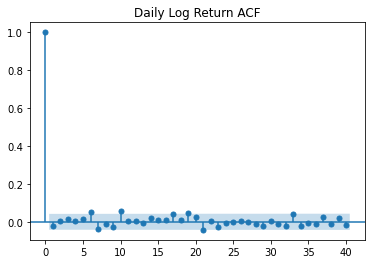

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
_ = plot_acf(logrtn, lags=40, title='Daily Log Return ACF')

In case of squared log return, we have a positive correlation up to 20 lag time steps. So we can confirm ARCH effects, testing for Heteroskedasticity should confirm later this.

* Fit a Gaussian ARMA-GARCH model to the log return series.  Perform model checking, including showing the normal QQ-plot of the standardized residuals.  Is the model adequate?

In [14]:
from arch import arch_model

logrtn100 = np.multiply(logrtn, 100)
#Fit Arma-Garch
am = arch_model(logrtn100, p=1, o=0, q=1, rescale= True)
res = am.fit(update_freq=5, disp="off")
print(res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5855.76
Distribution:                  Normal   AIC:                           11719.5
Method:            Maximum Likelihood   BIC:                           11742.3
                                        No. Observations:                 2188
Date:                Tue, May 25 2021   Df Residuals:                     2187
Time:                        22:13:13   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2399  7.332e-02      3.273  1.066e-03 [9.624e-0

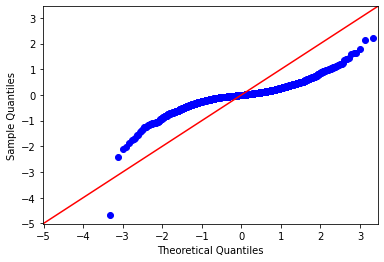

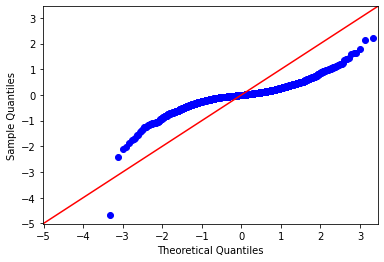

In [5]:
#Show QQ-Plot
sm.qqplot(res.resid, line ='45')

Testing for a Garch(1,1) both ARCH and GARCH parameters are highly significant with p-values close to 0 (transformation of results first)(alpha & beta). Also the sum ARCH and GARCH coeficients is close to 1 (.2399 +.7484) so the shocks will be highly persistent. The GARCH parameter is significant, a large return or loss will lead to higher volatility  for a prolonged time. The standardized residuals from the GARCH model approach a normal distribution.

* Build a volatility model of your choice for the log return series. You may create additional features/variables using the data, apply data transformations you consider relevant and you are not limited to any particular model form. Explain the choice of your model and its rationale. Perform model checking, and disclose relevant plots.  Is the model adequate?  Why?

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -5851.90
Distribution:                  Normal   AIC:                           11711.8
Method:            Maximum Likelihood   BIC:                           11734.6
                                        No. Observations:                 2188
Date:                Tue, May 25 2021   Df Residuals:                     2187
Time:                        22:23:47   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2658      0.101      2.637  8.373e-03 [6.821e-0

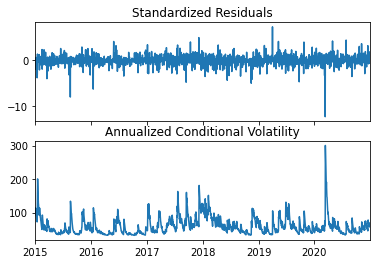

In [18]:
#EGARCH proposal
am2 = arch_model(logrtn100, p=1, q=1, rescale= True, vol="EGARCH")
res2 = am2.fit(update_freq=5, disp="off")
print(res2.summary())

According to Naimy and Zheng EGARCH(1,1) in 2018 seemed to be more accurate represent BTC volatility than GARCH(1,1) so it is proposed to verify this assumption and the relevance up to date. The results show a more significant alpha with a P Value less than .05 so the assumptions still holds.

Show a time-series plot of the estimated volatility series.

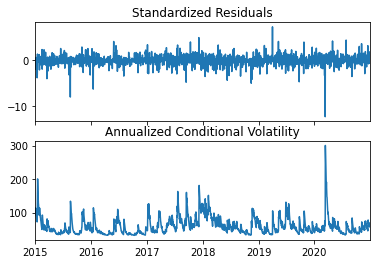

In [19]:
fig2 = res.plot(annualize="D")

Obtain 1-step to 5-step ahead mean and volatility  forecasts using the fitted model.

In [23]:
import datetime as dt

split_date = dt.datetime(2020,1,1)
res3 = am2.fit(last_obs=split_date)
forecasts1 = res3.forecast(horizon=5, start=split_date, reindex=True, method="simulation")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1295159160.037764
Iteration:      2,   Func. Count:     15,   Neg. LLF: 9082.515591612515
Iteration:      3,   Func. Count:     24,   Neg. LLF: 4973.359975267046
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4948.547967740671
Iteration:      5,   Func. Count:     36,   Neg. LLF: 5663923115.047078
Iteration:      6,   Func. Count:     44,   Neg. LLF: 4840.609538505665
Iteration:      7,   Func. Count:     49,   Neg. LLF: 4840.546324573646
Iteration:      8,   Func. Count:     54,   Neg. LLF: 4840.545159934942
Iteration:      9,   Func. Count:     59,   Neg. LLF: 4840.545120152592
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4840.545120154871
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4840.545120152592
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


In [26]:
print(forecasts1.mean.tail())
print(forecasts1.variance.tail())

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2020-12-27  0.163594  0.163594  0.163594  0.163594  0.163594
2020-12-28  0.163594  0.163594  0.163594  0.163594  0.163594
2020-12-29  0.163594  0.163594  0.163594  0.163594  0.163594
2020-12-30  0.163594  0.163594  0.163594  0.163594  0.163594
2020-12-31  0.163594  0.163594  0.163594  0.163594  0.163594
                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2020-12-27  17.752099  18.156015  18.498340  18.840761  19.052429
2020-12-28  17.296590  17.689969  18.014051  18.260502  18.533394
2020-12-29  14.718918  15.434496  15.908476  16.356858  16.779178
2020-12-30  17.504881  18.035347  18.186509  18.677730  19.182435
2020-12-31  14.411167  15.085999  15.654745  15.988749  16.478505


Compare the model from point 5 with the ARMA-GARCH model from point 4

EGARCH captures better volatility associated to time series than GARCH. However recent studies have proposed RNN methodologies to better model and forecasts Cryptos Volatility.